In [2]:
# Use the entire width of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

---

Here is a good resource explaining the details of choosing t and C for the Hamiltonian Simulation and the controlled rotation respectively.

---

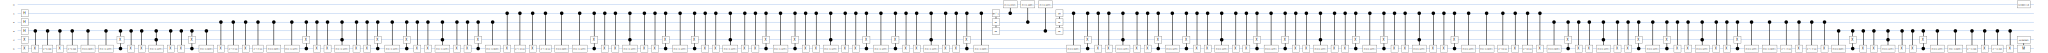

In [1]:
%reset -f


# Import the relevant libraries etc.

import cirq
from cirq.contrib.svg import SVGCircuit
from cirq.circuits import InsertStrategy

from math import pi
import sympy


# Set up the problem
a = 1
b = 0.2
#t = 2 * pi
# We are already dealing with the pi factor in the Hamiltonian Simulation portion below
t = 2/3

# Eigenvalue register size
n_l = 3

# Problem Size
n_b = 2

# Number of Trotter Steps
m = 1

# Constant C for this problem. This is recommended to be smaller than the smallest eigenvalue of the system.
C = 0.4






# Set up the registers

# Ancilla Qubit
anc = cirq.LineQubit(0)

# Eigenvalue register
q_l = []
for q in range(1,n_l + 1):
    q_l.append(cirq.LineQubit(q))
    
    
# Eigenvalue register
q_b = []
for q in range(n_l + 1,n_b + n_l + 1):
    q_b.append(cirq.LineQubit(q))



# Create the empty circuit
HHL_Circuit = cirq.Circuit()




# Flip some qubit to provide an input state
HHL_Circuit.append(cirq.X(q_b[0]))
HHL_Circuit.append(cirq.X(q_b[n_b-1]))



# Put the Eigenvalue Register in Superposition
for q in q_l:
    HHL_Circuit.append(cirq.H(q))
    
    

    

# Perform Hamiltonian Simulation    
    
# Bookmark the start and end for the uncompute phase
Ham_Start = len(HHL_Circuit.moments)




    

# First we must loop over the eigenvalue bits
for l in reversed(range(n_l)):
    
    # Define the U_1 and Rx gates here so that they can be reused

    # Only one U_1 gate needed throughout with the appropriate power
    #U_1_gate = cirq.ZPowGate(exponent=sympy.Symbol('a')*sympy.Symbol('t')/sympy.pi*2**(n_l-1-l))
    U_1_gate = cirq.ZPowGate(exponent=a*t/pi*(2**(n_l-1-l)))
    
    # We need to define three Rx gates: for the 2nd, 3rd/4th, and 5th terms
    #Rx_1 = cirq.rx(rads=-2*sympy.Symbol('b')*sympy.Symbol('t')/2/sympy.Symbol('m')*-1)
    Rx_1 = cirq.rx(rads=-2*b*t/2/m*-1)
    #Rx_2 = cirq.rx(rads=-2*sympy.Symbol('b')*sympy.Symbol('t')/sympy.Symbol('m'))
    Rx_2 = cirq.rx(rads=-2*b*t/m)
    #Rx_3 = cirq.rx(rads=-2*sympy.Symbol('b')*sympy.Symbol('t')/2/sympy.Symbol('m'))
    Rx_3 = cirq.rx(rads=-2*b*t/2/m)
    
    
    
    # Apply the first term, H1
    # The sequence of gates need not be repeated since the exponent can be taken into the Z gate
    HHL_Circuit.append([
        cirq.X(q_b[n_b-1]).controlled_by(q_l[l]),
        U_1_gate(q_b[n_b-1]).controlled_by(q_l[l]),
        cirq.X(q_b[n_b-1]).controlled_by(q_l[l]),
        U_1_gate(q_b[n_b-1]).controlled_by(q_l[l]),
    ],strategy=InsertStrategy.NEW)
    
    
    # Apply the second term, a piece of H2
    HHL_Circuit.append(Rx_1(q_b[n_b-1]).controlled_by(q_l[l]),strategy=InsertStrategy.NEW)
    
    
    # This is the loop for the repetition part
    for i in range(2**(n_l-1-l)):
        for m_i in range(m):
            
            # Apply the third term, a piece of H2
            HHL_Circuit.append(Rx_2(q_b[n_b-1]).controlled_by(q_l[l]),strategy=InsertStrategy.NEW)
            
            # Apply the fourth term, a piece of H3
            for j in range(1,n_b):
                # Here we construct each individual Cj
        
                # First identify the top and bottom qubit for this Cj
                bottom = n_b-1
                top = n_b-1 - j
                
                # Now apply the first operation, the controlled not gate
                HHL_Circuit.append((cirq.CNOT(q_b[top+1],q_b[top])).controlled_by(q_l[l]),strategy=InsertStrategy.NEW)
        
                # Now apply a not gate since we want to apply a series of not controlled nots
                HHL_Circuit.append((cirq.X(q_b[top+1])).controlled_by(q_l[l]),strategy=InsertStrategy.NEW)
        
                # Start the loop to insert the bunch of not controlled nots
                for k in range(top+2, bottom + 1):
                    # Apply the controlled not operations
                    HHL_Circuit.append((cirq.CNOT(q_b[top + 1], q_b[k])).controlled_by(q_l[l]),strategy=InsertStrategy.NEW)
        
        
                # Restore the qubit that we applied a not operation to 
                HHL_Circuit.append((cirq.X(q_b[top+1])).controlled_by(q_l[l]),strategy=InsertStrategy.NEW)
        
        
                # Here we apply the gate with multiple controls
                #gate = (cirq.X(q_b[top + 1])**(-sympy.Symbol('b')*sympy.Symbol('t')/sympy.pi/sympy.Symbol('m')/2)).controlled_by(q_b[top])
                gate = Rx_2(q_b[top + 1]).controlled_by(q_b[top])
                for k in range(top + 2, bottom + 1):
                    gate = gate.controlled_by(q_b[k])
                gate = gate.controlled_by(q_l[l])
                HHL_Circuit.append(gate, strategy=InsertStrategy.NEW)
        
        
                # Apply a not gate again since we want to apply a series of not controlled nots
                HHL_Circuit.append((cirq.X(q_b[top+1])).controlled_by(q_l[l]),strategy=InsertStrategy.NEW)
        
                # Start the loop to insert the bunch of not controlled nots
                for k in reversed(range(top+2, bottom + 1)):
                    # Apply the controlled not operations
                    HHL_Circuit.append((cirq.CNOT(q_b[top + 1], q_b[k])).controlled_by(q_l[l]),strategy=InsertStrategy.NEW)
        
        
                # Restore the qubit that we applied a not operation to 
                HHL_Circuit.append((cirq.X(q_b[top+1])).controlled_by(q_l[l]),strategy=InsertStrategy.NEW)
        
        
                # Apply the last operation, the controlled not gate
                HHL_Circuit.append((cirq.CNOT(q_b[top+1],q_b[top])).controlled_by(q_l[l]),strategy=InsertStrategy.NEW)
                
        


        
                
                
                
    

    # Apply the fifth and last term, another piece of H2
    HHL_Circuit.append((Rx_3(q_b[n_b-1]).controlled_by(q_l[l])),strategy=InsertStrategy.NEW)
    
    
# Bookmark the start and end for the uncompute phase
Ham_End = len(HHL_Circuit.moments)
    
    
    
# Now apply the inverse QFT
# The reversed version does seem to be the appropriate one
HHL_Circuit.append(cirq.qft(*q_l, inverse=True, without_reverse=False))

# Now apply the controlled rotation on the ancilla qubit
# Note that we are doing a very raw solver. If filter functions are used we can improve condition number dependence.
# This will be a series of controlled Y rotations with the powers dependent upon the qubit in the eigenvalue register we are controlling off of
for i in range(n_l):
    # Apply a Y rotation with the appropriate power
    # This is supposed to be a seried of controlled Y rotations. According to the 'Quantum Linear Solver: A Primer' we need to use the Ry gate.
    # However, we must note that Ry does theta/2 rotation while the definition given in the reference does a rotation of theta, so we will adjust for
    # that by multiplying the input argument of the rotation radians by 2
    # i is the qubit we are controlling off of
    Ry_gate = cirq.ry(rads=2*((n_l-i)**-2))
    HHL_Circuit.append(Ry_gate(anc).controlled_by(q_l[i]))
    # This is probably wrong. Check this against the textbook for the quantum computing course.
    


# Now apply the QFT
# The reversed version does seem to be the appropriate one
HHL_Circuit.append(cirq.qft(*q_l, inverse=False, without_reverse=False))

# Uncompute the Hamiltonian Simulation
# This involved both reversing the order of the gates in Hamiltonian Simulation and applying the inverse/hermitian conjugate/-1th powers of the gates
for i in reversed(range(Ham_Start, Ham_End)):
    HHL_Circuit.append(cirq.inverse(HHL_Circuit.moments[i]))


# Measure the ancilla. If 0 is found we have a solution, if 0 if measured, reset and start again.

HHL_Circuit.append(cirq.measure(anc, key= 'ancilla'),strategy=InsertStrategy.NEW)
HHL_Circuit.append(cirq.measure(*q_b, key= 'output'),strategy=InsertStrategy.INLINE)


        
        
        
# Check if the Circuit has been implemented as expected
SVGCircuit(HHL_Circuit)       

In [11]:
# Now let's try to run the circuit

simulator = cirq.Simulator()
result = simulator.run(HHL_Circuit, repetitions=100)

In [12]:
ancilla = result.measurements['ancilla']
output = result.measurements['output']


In [13]:

### This is NOT how this is done!
## Now we will try to extract the result by averaging over the outcomes
#successes = 0
#result = [0]*n_b
#for i in ancilla:
#    if i==1:
#        successes += 1
#        result += output[i]
#result = result/successes
#print(result)
        

In [14]:
print(sum(ancilla)/result.repetitions*100)

[44.]


In [15]:
output

array([[1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 1, 0, 0],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0,

In [16]:
# Try to run the circuit

# Create a simulator object
# A simulator object can either sun or simulate
# Run means we get actual measurements.
# Simulate gives us the complex state vector which we do not expect from an actual quantum measurement
# the _sweep suffix will allow us to pass a couple of parameters to the circuit.

# In this case we are interested in actually running the system and getting the results.
# We are also interested in running a sweep since we provide different values of a,b,t, m.




# The parameters of the circuit can take many different forms. 
#    cirq.Points: A list of manually specified values for one specific symbol as a sequence of floats
#    cirq.Linspace: A linear sweep from a starting value to an ending value.
#    cirq.ListSweep: A list of manually specified values for several different symbols, specified as a list of dictionaries.
#    cirq.Zip and cirq.Product: Sweeps can be combined list-wise by zipping them together or through their Cartesian product.

# A resolver can be used instead of parameter sweeps if we do not want to simulate over a range of values
# Try to resolve the parameters now
# This is not gonna work out because of the bug
#cirq.resolve_parameters(HHL_Circuit, {'a':a, 'b':b, 't':t, 'm':m})

# In this case we will create a List Sweep where we provide a list of dictionaries for the different cases we are interested in running.
# Each dictionary must be complete of course (meaning we need to provide values for all the paramters in each dictionary)
# param_sweep = cirq.Linspace('t', start=0, stop=2, length=200)


# Then we can simply simulate the sweeps
# trials = s.run_sweep(circuit, param_sweep, repetitions=1000)

# It appears that we do not need a parameter resolver since we are supplying the values using the parameter sweep object
# A parameter resolver simply returns the same object with the parameters resolved
# resolved_circuit = cirq.resolve_parameters(symbol_op, {'a':a, 'b':b, 't':t})
# We can try going this route if the parameter sweep is getting tedious or giving too much trouble



#simulator = cirq.Simulator()
#resolved_circuit = cirq.resolve_parameters(HHL_Circuit, {'a':a, 'b':b, 't':1, 'm':m})

#result = simulator.run_sweep(program = HHL_Circuit,
#                             ,
#                             repetitions=20)


